In [10]:
import pandas as pd
from utils import *

In [11]:
# Read data and calculate expanding loss throughout the tuning process
df = pd.read_csv("../reports/pretune/scheduled_exp.csv.zip")
df["accuracy"] *= 100
df["schedule"] = np.where(df["gamma"] < 1, "Exp", "Fixed")

In [13]:
# Calculate expanding pre-tuning accuracy for each config
df = df.sort_values(by="step")
df["loss"] = df["loss"].clip(df["loss"].quantile(0.99))
df['loss'] = df["loss"].fillna(df["loss"].quantile(0.99))
variables = ["dataset", "n_hidden_layers", "n_hidden_units", "n_samples", "schedule"]
dfs = []
for params, dfg in df.groupby(variables + ["base_lr", "gamma", "seed"]):
    dfg["expanding_loss"] = dfg["loss"].expanding().mean()
    dfs.append(dfg)
df = pd.concat(dfs)

In [14]:
# Get LRs that yield the smallest expanding loss for each config
best_lrs_pretune = get_best_params(
    df,
    params=["base_lr", "gamma"],
    fixed_params=variables + ["step", "seed"],
    metric=f"expanding_loss",
    mode="min"
)
best_lrs_pretune = best_lrs_pretune[
    variables + ["base_lr", "gamma", "step", "seed", "loss"]
]

In [15]:
# Get mean accuracy scores over rest of datastream for each config
stream_scores = pd.read_csv("../reports/model_sizes/scheduled_exp.csv.zip")
stream_scores["accuracy"] *= 100
stream_scores["schedule"] = np.where(stream_scores["gamma"] < 1, "Exp", "Fixed")
variables = [
    "base_lr",
    "n_hidden_layers",
    "n_hidden_units",
    "dataset",
    "gamma",
    "schedule",
]
mean_scores = agg_dataframe(stream_scores, cols_to_keep=variables)
mean_scores = mean_scores[variables + ["accuracy_mean"]]
mean_scores = mean_scores.rename(columns={"accuracy_mean": "accuracy"})

# Merge mean accuracy scores over datastreams into best parameters based on pre-tuning
pretuning_scores = best_lrs_pretune.merge(mean_scores)
pretuning_scores = pretuning_scores[
    ~pretuning_scores["dataset"].isin(["RBF incr.", "RBF static"])
]

In [16]:
# Get best accuracy scores for the datastreams
fixed_vars = ["dataset", "n_hidden_layers", "n_hidden_units", "schedule"]
best_lr_scores = get_best_params(
    mean_scores,
    params=["base_lr", "gamma"],
    fixed_params=fixed_vars,
    metric="accuracy",
)

# Get accuracy scores when choosing random params
random_lr_scores = agg_dataframe(
    stream_scores, cols_to_keep=fixed_vars, agg_fns=["mean"]
)

best_lr_scores = best_lr_scores.rename(
    columns={"accuracy": "accuracy_upper", "base_lr": "best_lr"}
)
random_lr_scores = random_lr_scores.rename(
    columns={"accuracy_mean": "accuracy_lower", "base_lr_mean": "mean_lr"}
)
bounds = best_lr_scores.merge(random_lr_scores)

# Merge random and best accuracy scores into pre-tuning scores
pretuning_scores = pretuning_scores.merge(bounds, on=fixed_vars)
pretuning_scores = pretuning_scores.sort_values(by=["step"])

In [17]:
mean_pretuning_scores = agg_dataframe(
    pretuning_scores,
    cols_to_keep=[
        "n_samples",
        "n_hidden_layers",
        "n_hidden_units",
        "step",
        "schedule",
    ],
)
mps = mean_pretuning_scores.rename(
    columns={
        "accuracy_upper_mean": "accuracy_upper",
        "accuracy_lower_mean": "accuracy_lower",
    }
)

In [18]:
def make_pretuning_plots(dfp, ax=None, var_y="accuracy", figsize=(5, 3)):
    cmapper = ValueColorMapper(dfp["n_samples"].unique(), cmap="viridis")
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for n_samples, df_n_samples in dfp.groupby("n_samples"):
        steps = df_n_samples["step"]
        scores = df_n_samples[f"{var_y}_mean"]
        stds = df_n_samples[f"{var_y}_std"]
        color = cmapper(n_samples)
        ax.plot(
            steps,
            scores,
            c=color,
            label=f"{n_samples} Samples",
        )
        ax.fill_between(
            steps,
            scores - stds,
            scores + stds,
            color=color,
            edgecolor="none",
            alpha=0.2,
        )
    if f"{var_y}_upper" in df_n_samples:
        ax.plot(
            df_n_samples["step"],
            df_n_samples[f"{var_y}_upper"],
            linestyle="dashed",
            c="black",
            label="Best LR",
        )
    if f"{var_y}_lower" in df_n_samples:
        ax.plot(
            df_n_samples["step"],
            df_n_samples[f"{var_y}_lower"],
            linestyle="dotted",
            c="black",
            label="Random LR",
        )
    return ax

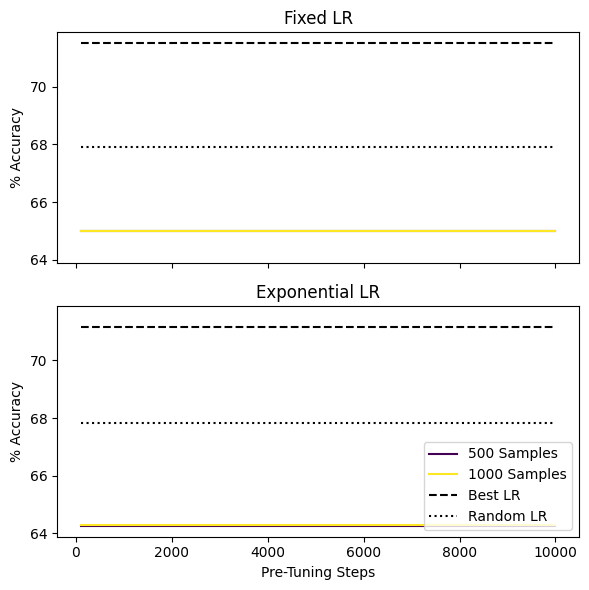

In [19]:
dfp = mps[(mps["n_hidden_layers"] == 1) & (mps["n_hidden_units"] == 64)]
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True, sharey=True)
make_pretuning_plots(dfp[dfp["schedule"] == "Fixed"], axs[0])
make_pretuning_plots(dfp[dfp["schedule"] == "Exp"], axs[1])
axs[1].legend(loc=("lower right"))
axs[1].set_xlabel("Pre-Tuning Steps")
axs[0].set_ylabel("Accuracy [%]")
axs[1].set_ylabel("Accuracy [%]")
axs[0].set_title("Fixed LR", fontsize=12)
axs[1].set_title("Exponential LR", fontsize=12)
plt.tight_layout()
plt.savefig("../pub/figures/loss_pretune_1x64_fixed_vs_exp_schedule.pdf")

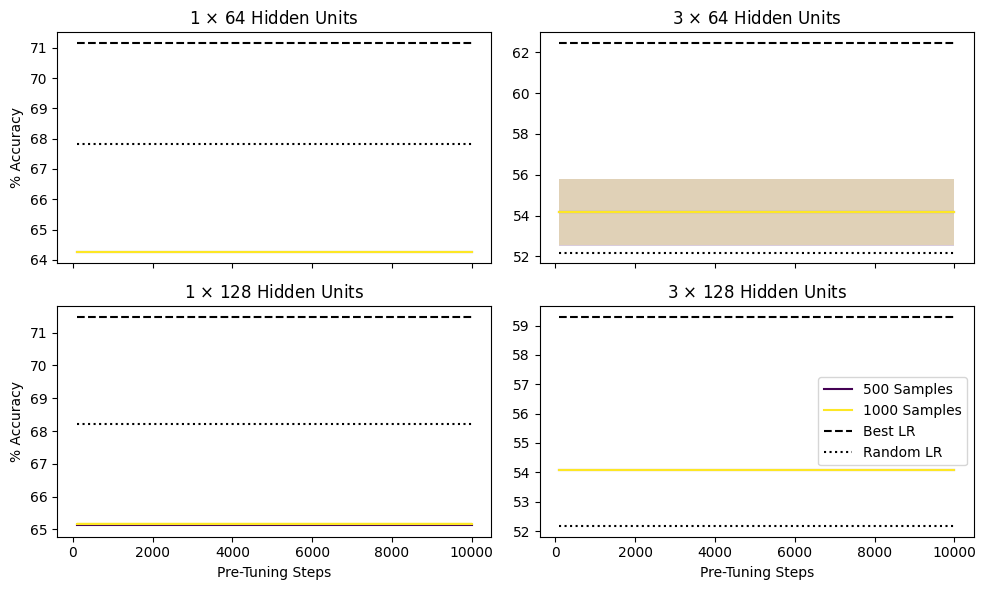

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=False)
dfp = mps[(mps["schedule"] == "Exp")]
rowmap = {64: 0, 128: 1}
colmap = {1: 0, 3: 1}
for n_units, dfw in dfp.groupby("n_hidden_units"):
    for n_layers, dfl in dfw.groupby("n_hidden_layers"):
        ax = axs[rowmap[n_units], colmap[n_layers]]
        make_pretuning_plots(dfl, ax)
axs[0, 0].set_title(r"1 $\times$ 64 Hidden Units", fontsize=12)
axs[0, 1].set_title(r"3 $\times$ 64 Hidden Units", fontsize=12)
axs[1, 0].set_title(r"1 $\times$ 128 Hidden Units", fontsize=12)
axs[1, 1].set_title(r"3 $\times$ 128 Hidden Units", fontsize=12)
axs[1, 0].set_xlabel("Pre-Tuning Steps")
axs[1, 1].set_xlabel("Pre-Tuning Steps")
axs[0, 0].set_ylabel("Accuracy [%]")
axs[1, 0].set_ylabel("Accuracy [%]")
axs[1, 1].legend()
plt.tight_layout()
plt.savefig("../pub/figures/loss_pretune_architectures_exp_schedule.pdf")

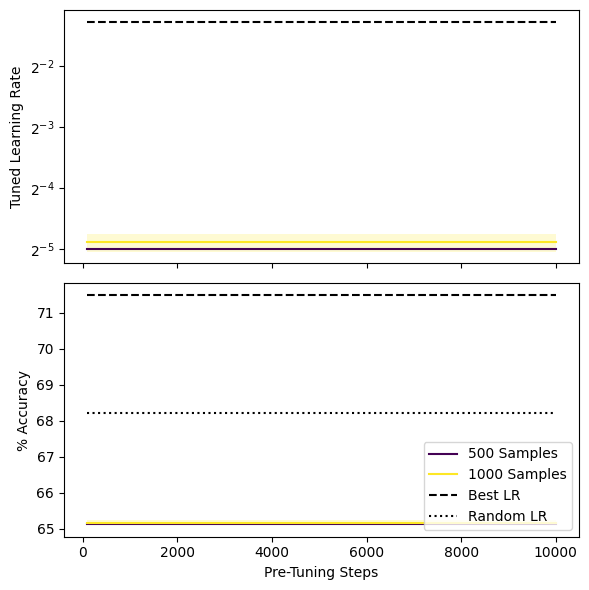

In [21]:
dfp = mps[
    (mps["schedule"] == "Exp")
    & (mps["n_hidden_layers"] == 1)
    & (mps["n_hidden_units"] == 128)
]
dfp = dfp.rename(columns={"best_lr_mean": "base_lr_upper"})
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
make_pretuning_plots(dfp, axs[0], var_y="base_lr")
make_pretuning_plots(dfp, axs[1], var_y="accuracy")
axs[0].set_yscale('log', base=2)
axs[1].set_xlabel("Pre-Tuning Steps")
axs[1].set_ylabel("Accuracy [%]")
axs[0].set_ylabel("Tuned Learning Rate")
axs[1].legend(loc="lower right")
plt.tight_layout()
plt.savefig("../pub/figures/loss_pretune_1x128_acc_lr_exp_schedule.pdf")